# CHARACTERISTICS OF POPULAR SONGS ON SPOTIFY

> ## REPORT BY CHRISTABEL DANQUAH

> Gathered first dataset with Anita, Indira, and Yinghua. 

In this Notebook, I'll take a look at some of the characteristics of the top songs in my Spotify database.

I’ll take a look at the audio features and try to highlight the common patterns behind the audio features of these  popular songs.

## About The Database
The first dataset I chose to work with had a lot of qualitative data. <br>
But as I created the database and came up with my theme and what I would like to analyse, I realised I needed more than one dataset.<br>
So I found 5 more datasets that complemented each other with quantitative data to provide a comprehensive analysis.

After merging, cleaning, removing null values, etc. I ended up with four tables namely:

1. artists <br>
Contains Artists names and ID

2. country <br>
Contains the name of Artists country of origin and its ID

3. genre <br>
Contains the genre name and ID

4. songs <br>
Contains all quantitative data of the song, in other words metadata of the songs. It contains attributes like:
- Danceability
    - It describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. <br>
      A value of 0.0 is least danceable and 1.0 is most danceable.

- Energy
    - It is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. <br>
    Typically, energetic tracks feel fast, loud, and noisy. 

- Pitch_key
    - The key the track is in.

- Mode
    - It indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. <br> 
      Major is represented by 1 and minor is 0.

- Spechiness
    - It measures the presence of spoken words in a track. <br>
      Values above 0.66 indicate mostly spoken words, 0.33–0.66 suggest a mix of speech and music (e.g., rap), <br>
      and below 0.33 represents primarily musical tracks.

- Acousticness
    - It is a confidence measure from 0.0 to 1.0 of whether the track is acoustic. <br>
      1.0 represents high confidence the track is acoustic.

- Instrumentalness
    - Predicts whether a track contains no vocals. <br>
    The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. <br>
    Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

- Liveness 
    - Detects the presence of an audience in the recording. <br>
    Higher liveness values represent an increased probability that the track was performed live. <br>
    A value above 0.8 provides strong likelihood that the track is live.

- Valence
    - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. <br>
    Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), <br>
    while tracks with low valence sound more negative (e.g. sad, depressed, angry).

- Tempo
    - The overall estimated tempo of a track in beats per minute (BPM). <br>
    In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

- Accumulated_streams
    - Total number of streams the song has accumulated on Spotify.

- Avg_streams_per_day
    - The number of streams the song receives on average per day.

- Popular_year
    - The year in which the song was most popular.


### Helpful Links

[Interactive Figures](https://matplotlib.org/stable/users/explain/figure/interactive.html#jupyter-notebooks-jupyterlab)

[Seaborn](https://seaborn.pydata.org/tutorial/introduction.html)

[Density Plot](https://stackoverflow.com/questions/4150171/how-to-create-a-density-plot)

[Plot types](https://matplotlib.org/stable/gallery/index.html)


<img alt="Spotify ERD" height="900" src="img/spotifyERD.png" width="800"/>

In [26]:
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, URL
import pandas as pd
import seaborn as sns
import numpy as np


url = URL.create(
    drivername="mssql+pyodbc",
    host="localhost",
    database="spotify",
    query={"driver": "ODBC Driver 17 for SQL Server", "trusted_connection": "yes"}
)

conn = create_engine(url)


> Let's start by checking what genre the songs belong to.

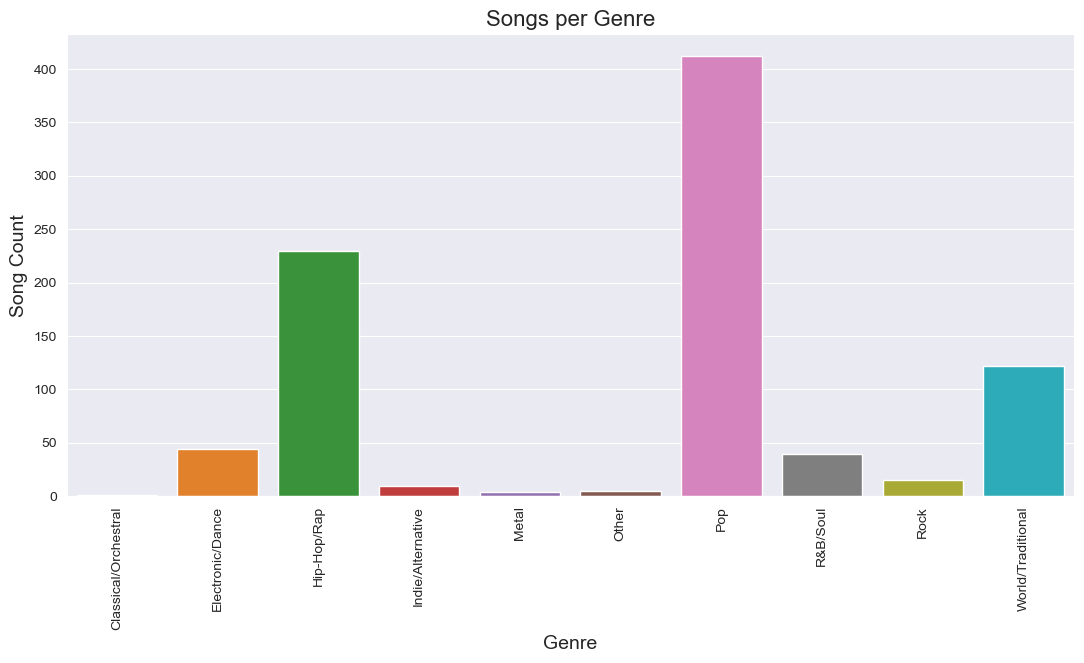

In [116]:
df = pd.read_sql_query("""
    SELECT 
        a.artist_name, 
        s.accumulated_streams,
        s.song_title,
        g.genre_name
    FROM songs AS s
    INNER JOIN artists AS a ON a.artist_id = s.artist_id
    INNER JOIN genre AS g ON g.genre_id = s.genre_id
    ORDER BY s.accumulated_streams DESC
    """, con=conn)

# count how many times each artist appears in each genre
song_counts = df.groupby(["genre_name"]).size().reset_index(name="song_count")

sns.set_palette("tab10")

plt.figure(figsize=(13, 6))
bar_plot = sns.barplot(x="genre_name", y="song_count", data=song_counts)

plt.title("Songs per Genre", fontsize=16)
plt.xlabel("Genre", fontsize=14)
plt.ylabel("Song Count", fontsize=14)

plt.xticks(rotation=90)
plt.yticks()
plt.show()

>From our plot above we can tell Pop is the most popular genre with 412 songs followed by Hip-Hop/Rap with 230 songs, a noticeable gap. <br>
>Metal and Classical/Orchestral seems to be the least popular with 4 and 1 song respectively.

> The gap between all other genres and Pop and Hip-Hop/Rap is huge, so lets dive deeper into those genres. <br>
> What countries are the Artists in Pop and Hip-Hop/Rap from?

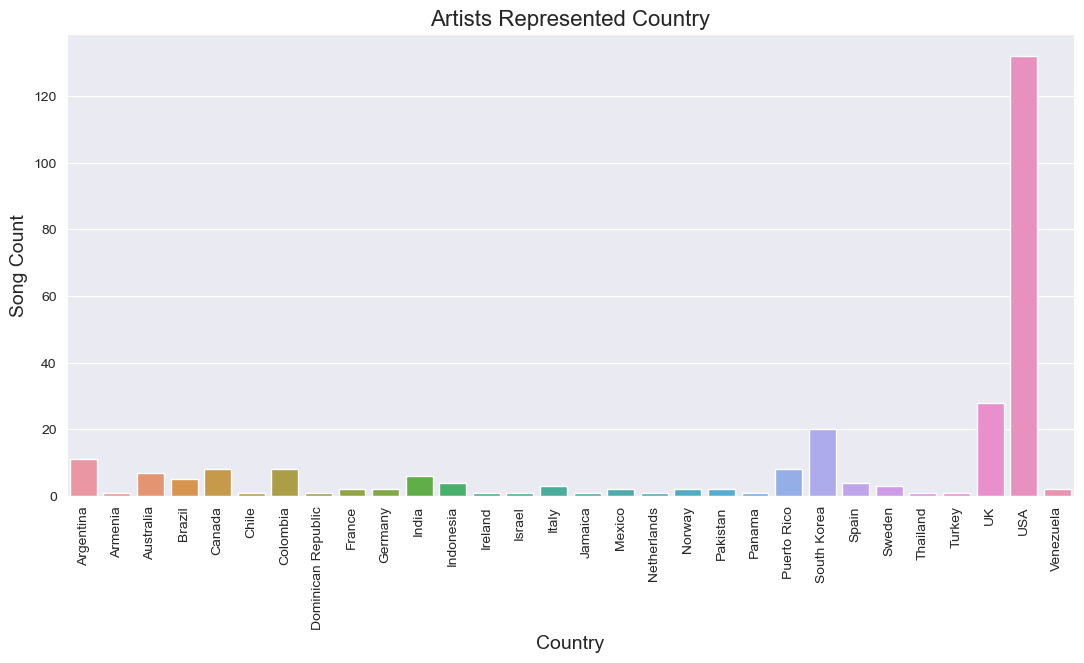

In [115]:
df = pd.read_sql_query("""
    SELECT 
        a.artist_name, 
        s.accumulated_streams,
        s.song_title,
        g.genre_name,
        c.country_name
    FROM songs AS s
    INNER JOIN artists AS a ON a.artist_id = s.artist_id
    INNER JOIN genre AS g ON g.genre_id = s.genre_id
    INNER JOIN country AS c ON c.country_id = a.country_id
    WHERE g.genre_name = 'Pop' OR g.genre_name = 'Hip-Hop/Rap'
    ORDER BY s.accumulated_streams 
    """, con=conn)

# grouping each unique artist by the countries and counting them
artists_counts = df.groupby(["country_name"])["artist_name"].nunique().reset_index(name="unique_artist_count")

sns.set_palette("tab10")

plt.figure(figsize=(13, 6))
sns.barplot(x="country_name", y="unique_artist_count", data=artists_counts)

plt.title("Artists Represented Country", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Song Count", fontsize=14)

plt.xticks(rotation=90)
plt.yticks()
plt.show()

> Hip-Hop/Rap and Pop have 642 songs combined, and 315 unique artists. <br>
> From our graph above, out of the 315 unique artists,a whopping 132 are from the USA, which is almost half of our artists. <br>
> UK follows with 28 artists and South Korea next with 20 artists.

> I would now like to see how many songs the top 20 artists in these two genres have produced.

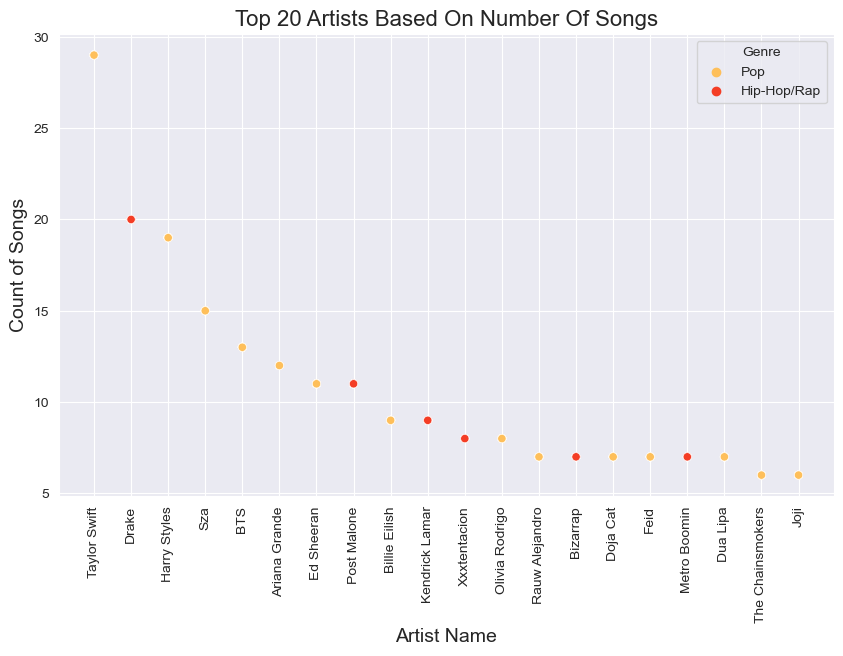

In [113]:
df = pd.read_sql_query("""
    SELECT 
        a.artist_name, 
        s.accumulated_streams,
        s.song_title,
        g.genre_name
    FROM songs AS s
    INNER JOIN artists AS a ON a.artist_id = s.artist_id
    INNER JOIN genre AS g ON g.genre_id = s.genre_id
    WHERE g.genre_name = 'Pop' OR g.genre_name = 'Hip-Hop/Rap'
    ORDER BY s.accumulated_streams DESC
    """, con=conn)


# top 20 artists with the highest appearance
top_artists = df["artist_name"].value_counts().head(20)


# converting it back to a df to make it easier to plot
top_artists_df = top_artists.reset_index()
top_artists_df.columns = ["artist_name", "count"]

# merging the top 20 artists with their genre to include genre information by using a left join
top_artists_df = top_artists_df.merge(df[["artist_name", "genre_name"]], on="artist_name", how="left")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=top_artists_df, x="artist_name", y="count", hue="genre_name", palette="YlOrRd")

plt.title("Top 20 Artists Based On Number Of Songs", fontsize=16)
plt.xlabel("Artist Name", fontsize=14)
plt.ylabel("Count of Songs", fontsize=14)
plt.legend(title="Genre")
plt.xticks(rotation=90)

plt.show()

>Taylor Swift is leading with 29 songs in the Pop Genre (she is the Queen of Pop after all, no shade to Madonna), <br>
> followed by Harry Styles with 19 songs.

> In the Hip-Hop/Rap genre, Drake leads with 20 songs followed by Post Malone with 11 songs.

> Now I'm going to see the frequency of the pitch keys in Pop and Hip-Hop/Rap

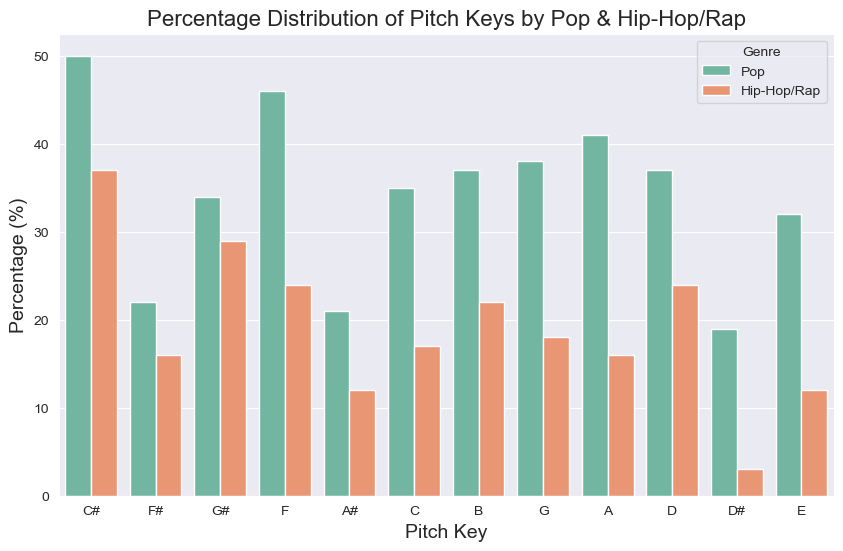

In [114]:
df = pd.read_sql_query("""
    SELECT 
        g.genre_name,
        s.pitch_key
    FROM songs as s
    INNER JOIN genre AS g ON g.genre_id = s.genre_id
    WHERE g.genre_name = 'Pop' OR g.genre_name = 'Hip-Hop/Rap'
    ORDER BY accumulated_streams DESC
    """, con=conn)

# counting the number of pitch keys for the genres
normalized_df = (df.groupby(["genre_name", "pitch_key"]).size().reset_index(name="count"))

# dividing each count by the total counts per genre to calculate their percentages
total_counts = normalized_df.groupby("genre_name")["count"].transform("sum")
normalized_df["percentage"] = normalized_df["count"] / total_counts * 100

# separating the genres with the hue
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="pitch_key", hue="genre_name", palette="Set2")

plt.xlabel("Pitch Key", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.title("Percentage Distribution of Pitch Keys by Pop & Hip-Hop/Rap", fontsize=16)
plt.legend(title="Genre")

plt.show()

>So, it seems like the most common key is C# with F in tow; while D# is the least popular for Pop. <br>
> For Hip-Hop/Rap, C# is the most popular as well but followed by G#.

>Let's examine some of the audio features of the songs in the common keys for both genres.

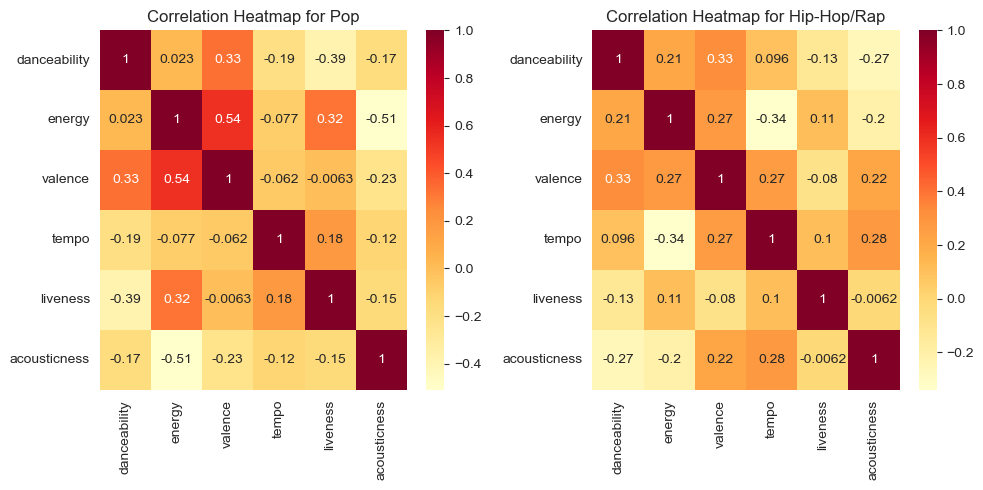

In [104]:
df = pd.read_sql_query("""
    SELECT 
        a.artist_name,
        s.danceability,
        s.energy,
        s.valence,
        s.tempo,
        s.liveness,
        s.acousticness,
        g.genre_name
    FROM songs AS s
    INNER JOIN artists AS a ON a.artist_id = s.artist_id
    INNER JOIN genre AS g ON g.genre_id = s.genre_id
    WHERE (g.genre_name = 'Pop' OR g.genre_name = 'Hip-Hop/Rap')
    AND s.pitch_key = 'C#'
    ORDER BY s.accumulated_streams DESC
    """, con=conn)

 # creating df for pop and hiphoprap
pop = df[df["genre_name"] == "Pop"]
hiphoprap = df[df["genre_name"] == "Hip-Hop/Rap"]

# creating subplots, two correlation plots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# correlation heatmap for pop
pop_corr = pop[["danceability", "energy", "valence", "tempo", "liveness", "acousticness"]].corr()
sns.heatmap(pop_corr,annot=True,cmap="YlOrRd", ax=axes[0])
axes[0].set_title("Correlation Heatmap for Pop")

# correlation heatmap for hip-hop/rap
hiphoprap_corr = hiphoprap[["danceability", "energy", "valence", "tempo", "liveness", "acousticness"]].corr()
sns.heatmap(hiphoprap_corr,annot=True,cmap="YlOrRd", ax=axes[1])
axes[1].set_title("Correlation Heatmap for Hip-Hop/Rap")

plt.tight_layout()
plt.show()

> Danceability has the same relationship with Valence in both Hip-Hop/Rap and Pop (0.33), <br>
> suggesting that danceable songs in both genres are similarly linked to positivity. <br>
> Which makes sense because songs that are danceable tend to have a positive or happy mood.

>In both genres, Valence has a positive correlation with Energy, but it is stronger in Pop (0.54) compared to Hip-Hop/Rap (0.27). <br>
> This implies that in Pop, happier songs are more clearly tied to higher energy levels.

>Tempo and Danceability have a very weak positive correlation (0.096) in Hip-Hop/Rap, <br> 
> suggesting tempo has little effect on how danceable Hip-Hop/Rap songs are. <br>
> A weak negative correlation (-0.19) in Pop, suggesting that faster tempos don't necessarily mean more danceable songs. <br>
>This low correlation is interesting to me, because i kind of expected Tempo to correlate positively with Danceability, <br>
> since faster songs are more upbeat and energetic, moving people to dance. <br>
> But I guess that is not the case, since tempo is just one piece of the whole picture. <br>
> In Hip-Hop/Rap, slower tracks often feature strong rhythms and grooves that boost danceability, <br>
> while faster tracks with complex flows may be harder to dance to. <br>
> Similarly, in Pop, faster songs may prioritize energy over groove, whereas slower tracks with steady beats can feel more danceable.

> Now since Energy, Valence, and Danceability are positively correlated, I'm going to see how they are distributed in the Pop Genre.



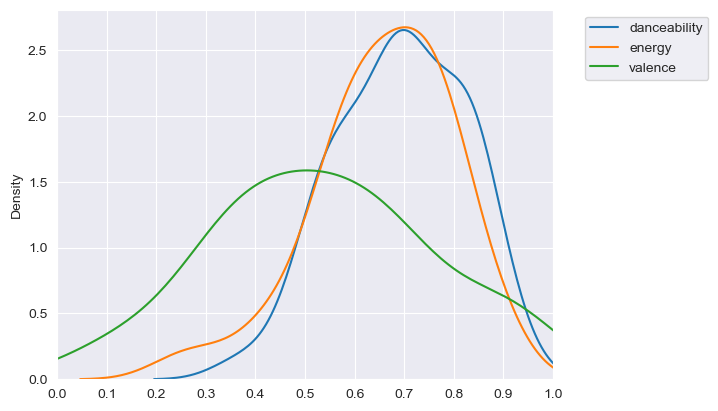

In [105]:
df = pd.read_sql_query("""
    SELECT
        danceability,
        energy,
        valence
    FROM songs as s
    INNER JOIN genre AS g ON g.genre_id = s.genre_id
    WHERE g.genre_name = 'Pop'
    AND s.pitch_key = 'C#'
    ORDER BY accumulated_streams DESC
    """, con=conn)

# creating a df for the three audio features
dance = df["danceability"]
energy = df["energy"]
valence = df["valence"]

# creating the kernel density estimation (kde)
sns.kdeplot(np.array(dance), label = "danceability")
sns.kdeplot(np.array(energy), label = "energy")
sns.kdeplot(np.array(valence), label = "valence")

plt.legend(labels = ["danceability","energy","valence"], bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, 1)
plt.show()


> From the density plot above, most songs have high Danceability and Energy, <br>
> meaning they are good for dancing and energetic.

> Valence is lower, showing that the songs are more neutral or slightly less happy in mood.

## Reflections

Initially I wanted to mainly do a year-to-year analysis of the songs. <br>
But after merging the datasets, a lot of datapoints had null values and had to be deleted, so I had to scratch my initial plan and analyse the whole dataset. <br>
Even though lots of data was deleted; mostly qualitative data, I gained a lot of quantitative data (audio features) which expanded what I wanted to do. <br>
I was able to analyse the songs in depth.

## Conclusion
From my analysis, to succeed in the music industry, focusing on the Pop genre and being based in the USA would offer the best chances of success. <br>
While the Hip-Hop/Rap genre is also a strong option, Pop song in the C# key stands out as the most promising path.

In the Pop genre, creating songs with high danceability, high energy and a positive, upbeat vibe (valence) would be key to capturing listeners and achieving success. <br>

The density plot shows that Pop songs in C# key thrive on danceability and energy with a little spice of happiness or a neutral mood. <br>
Watch out for the next Taylor Swift!

> ### THANK YOU!